## Prerequisites

torch==1.1.0

In [224]:
import random
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn 

from gensim.models import KeyedVectors
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
df = pd.read_csv("../jigsaw-toxic-comment-classification-challenge/train.csv")

In [ ]:
df.head()

In this notebook you will learn pytorch basics, this framework will help you to build simple neural networks during this task.   
The first neural network we will try to learn is Feed Forward Neural Network which contain one Fully Connected Layer.  
It can have 1 or more fully connected layers, also it could be called as MLP - multilayer perceptron. 

Read about PyTorch here:  
https://en.wikipedia.org/wiki/PyTorch

And here:

https://neurohive.io/ru/tutorial/glubokoe-obuchenie-s-pytorch/

While reading these articles probably you will meet some unknown terms: 
backpropagation algorithm, gradient descent, activation function, loss function, etc.  
Please, try to look for an information about why do you need all of these stuff. 

Answer this questions about Neural Nets: 

1. In previous tasks we created some features manually, tried to weight our features, tried to select special words for vectorization, how deep learning solves this problem? 

2. Why do we work with tensors in PyTorch?

3. Please, find and read information - why do we need an activation functions in our models? Please, refer to the XOR problem with MLP without activation function, find information about it and answer the previous question. 

4. Please, answer the following question - what gradient is? Why do we need gradient descent algorithm? Which problem it solves? 

5. What is backpropagation algorithm? 

6. What is loss function? 

1.  Взять тот же Word2Vec, там есть реализация простой нейронной сети. Именно и она есть способом решения поставленной в вопросе проблемы. Дело в гибкости и настраиваемости параметров модели.

2. По сути, тензоры библиотеки pytorch - те же многомерные массивы библиотеки numpy, обладающие аналогичными возможностями. Используються для вычислений. Если ещё глянуть документацию и поверить в написанное (но лучше проверить, что я и сделал), то вычисления на тензорах могут проводиться как на центральном процессоре, так и на графическом.

3.  Активационный процесс заключается в том, когда при необходимом количестве входных данных нейрон передаёт значение далее по сети. Преобразовазованием этого значения занимается функция активации нейрона. Примеры активационных функций - сигмоидная функция (tanh, логистическая, ...), Хэвисайда и т.д.
<br>
Активационные функции необходимы для гибкости нейронной сети. Ними же решалась задача о линейной несепарабельности данных проблемы XOr.

4. Пусть $\Omega \subset \mathbb{R}^d (d \in \mathbb{N})$ - область в $\mathbb{R}^d$. Тогда функция $\phi: \Omega \rightarrow \mathbb{R}$ - скалярное поле.
<br>
Градиентом $\phi$ является следующее выражение:
$\nabla \phi = (\frac{\partial \phi}{\partial t_1}, \frac{\partial \phi}{\partial t_2}, \ldots, \frac{\partial \phi}{\partial t_d})$,<br>
где $\frac{\partial \phi}{\partial t_j}$ - частная производная $\phi$ за переменной $t_j$. Градиент отождествляют с направлением в $\Omega$, в котором $\phi$ возрастает быстрее всего.
<br>
Градиентный спуск - метод нахождения локального экстремума некоторой функции с применением её (отрицательного) градиента. В машинном обучении,если рассматривать нейронные сети, то указанный метод используется в обучении модели в качестве принципа обратного распространения ошибки (backpropagation method). Там же и берётся градиент от функции ошибок (она же определяет качество работу нейронной сети в период циклического обучения).
<br>
Градиентный спуск используется для решения задачи минимизации среднего значения ошибки на выходе нейронной сети, обновляя весовые параметры модели.

5. Принцип обратного распространения ошибки - способ вычисления градиента функции, который используется при обновлении параметров многослойного персептрона. Цель - минимизация ошибки и получение желаемого результата.

6. Функция потерь - чувствительная к выбросам функция несогласия наблюдаемых данных и тех, что были предсказаны так званой подогнанной функцией модели.

Read the following article:

https://en.wikipedia.org/wiki/Feedforward_neural_network

What is FFNN? 

Нейронная сеть с прямой связью - тип сети, где входные данные обрабатывается из одного конца потока в другой, при этом поток состоит из последовательно соединенных нейронов, которые передают необходимые сигналы.
<br>
Для такого типа сетей циклы или петли обратной связи не характерны.
<br>
Простые примеры сетей такого плана: персептроны однослойные и многослойные.

## PyTorch basics

#### Autograd

In [ ]:
# Creating a tensor:
x = torch.ones(1, requires_grad=True)

print(x.grad)    # returns None

print(x.grad) is None because a tensor x is a scalar, so there is nothing to be calculated.

In [ ]:
x = torch.ones(1, requires_grad=True)
y = 20 + x
z = (y ** 2) * 2 
z.backward()     # auto gradient calculation

print(x.grad)    # ∂z/∂x 

### Prepare the data

In [ ]:
df.head()

In [ ]:
# Modify labels dtype to 'int', to make summarizing them possible
for column in df.columns: 
    if column not in ['id', 'comment_text', 'cleaned']:
        df[column] = df[column].astype('int32')
        
# Create a toxicity column (sums all of the toxic labels)
df['toxicity'] = df.iloc[:,2:8].sum(axis=1)

# Clean data - where toxicity is == 0 
clean = df[df['toxicity'] == 0]
# Messages, which were labelled as obscene
obscene = df[df['obscene'] == 1]

# Create a dataset for binary classification 
df_binary = clean.append(obscene, ignore_index=True, sort=False)

In [ ]:
# Shuffle
df_binary = df_binary.sample(frac=1)

# Reset index of the pd.DataFrame
df_binary.reset_index(inplace=True)

In [ ]:
df_binary.head()

In [ ]:
#df_binary.to_csv("../jigsaw-toxic-comment-classification-challenge/df_binary.csv")

In [ ]:
# Load W2V model 
import gensim.downloader as api
we_model = KeyedVectors.load_word2vec_format('../task-4/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# Make stratified sampling, for example: select 500 examples with obscene == 1, and 500 clean examples. 
# Select only a small sample of your data (20%), do not train your model on all of the data available 
# But to make the task easier, make a stratified selection 
# (number of 1 labels would be approximately equal to number of 0 labels)
''' TASK HERE'''

df_sample, _ = train_test_split(df_binary, train_size = 0.35)

# Split the data on the stratified training and test data sets 
''' TASK HERE'''

df_train, df_test = train_test_split(
    df_sample, train_size = 0.75, stratify = df_sample.obscene)

In [ ]:
print("Train shape: {}".format(df_train.shape))
print("Test shape: {}".format(df_test.shape))

In [ ]:
def get_vectors(df_sample): 
    '''
    This function would process a DataFrame creating lists of:
        vectors, labels and documents corresponding to each raw document. 
        
    Args: 
        df: pd.DataFrame - DF to vectorize
    Returns: 
        X: list - Vectorized documents, each value in a list is a torch.tensor
        labels: list - Labels for each document, each value in a list is a torch.tensor
        documents: list - List of the raw texts of the vectorized documents 
    '''
    
    # Obtain vectors for documents, vectorized documents list and labels
    X, labels, documents = [], [], []
    for i, (document, tokens, label) in enumerate(zip(df_sample.comment_text, df_sample.cleaned, df_sample.obscene)):
        row_vectors = []
        for kw in tokens:
            try: 
                row_vectors.append(we_model[kw])
            except (IndexError, KeyError): 
                continue
        if not row_vectors:
            continue
        row_vectors = np.asarray(row_vectors)
        vec = row_vectors.mean(axis=0)
        X.append(torch.tensor(vec))
        documents.append(document)
        labels.append(torch.tensor(label, dtype=torch.float))
        
    return X, labels, documents

In [ ]:
X_train, y_train, documents_train = get_vectors(df_train)
X_test, y_test, documents_test = get_vectors(df_test)

### How to create a simple NN: 

In [ ]:
# Modify your model to work with batches, not only single item. 
''' TASK HERE'''

class FeedForward(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = nn.ReLU()
        self.logits = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Makes a forward pass 
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        logits = self.logits(relu)
        output = self.sigmoid(logits)
        return output

In [ ]:
model = FeedForward(300, 200)
#model.to(device)

In [ ]:
# Initialise the model 


# Specify loss and optimization functions:

# specify loss function
criterion = nn.BCELoss()
# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

# Move model to the training mode
model.train()

# init n_epochs 
n_epochs = 10

# init number of iterations for one epoch 
# we want our model during the epoch to walk trough all of the training examples 
# for batch_size == 1, number of iterations would be equal to number of examples 
# in the training set 
n_iters = len(X_train)

# initialise batch_size
# NOTE! for now it's equal == 1, you need to modify your model to make it possible to work with 
# batches during training, not only making an update for a single example 
batch_size = 1
for epoch in range(n_epochs):  
    epoch_loss = 0
    for idx in range(n_iters):
        
        # Selects only 1 sample, modify it to select N samples, N == batch_size
        ''' TASK HERE'''
        # idx = random.sample(range(len(X_train)), 1) # TIP: You can random sample N examples 
        
        optimizer.zero_grad()    # Forward pass

        # Select corresponding data from:
        # X (vectors) and labels - for calculating the loss and making a backward pass 
        # backward pass - updating our weights according to the obtained loss 
        ''' TASK HERE'''
        x = X_train[idx]
        y_true = y_train[idx]
        
        #x = x.to(device)
        #y_true = y_true.to(device)

        y_pred = model(x)    # Compute Loss
        loss = criterion(y_pred.squeeze(), y_true)
        
        epoch_loss += loss.item() / n_iters
        loss.backward()   # Backward pass 
        optimizer.step()
        
    print('Epoch {}: train loss: {}'.format(epoch, epoch_loss))    # Backward pass

In [ ]:
def make_predictions(model, X_test, y_test, documents_test, threshold, prints = True): 
    n_prints = 0
    preds = []
    for example, label, document in zip(X_test, y_test, documents_test):
        pred = model(example)
        y_pred = int(pred.item() > threshold)
        preds.append(y_pred)
        
        # Print some examples with obscene documents texts and predicted and true labels 
        if label.item() == 1.0 and n_prints < 10 and prints:
            print("Predicted label: {}".format(y_pred))
            print("True label: {}".format(label.item()))
            print("Document: {}".format(document))
            print("*-*-"*20)
            n_prints += 1
        
    return preds

In [ ]:
# Move model to the eval mode before making a prediction
model.eval()
preds = make_predictions(model, X_test, y_test, documents_test, threshold=0.5)

test_labels = [label.item() for label in y_test]

In [ ]:
print(classification_report(test_labels, preds))

In [ ]:
# init classification report

Results to beat:

|         | precision | recall | f1-score | support |
|---------|-----------|--------|----------|---------|
|0.0      |0.98       |0.99    |0.99      |5724     |
|1.0      |0.87       |0.62    |0.72      |337      |
|acc      |           |        |0.97      |6061     |
|macro avg|0.92       |0.81    |0.86      |6061     |
|wghtn avg|0.97       |0.97    |0.97      |6061     |

## Task 1: 

#### Find all of the ''' TASK HERE ''' messages. 

1. Create stratified dataset, make your classes balanced! Train the model. Try to beat the initial score.

2. While vectorizing by W2V model, add tf-idf weightning, look at TfidfVectorizer at sklearn. 

3. Add batch size, modify your model architecture to make it possible to process batches, not only single items. 

4. Change hidden_size, n_layers, activation function, etc to modify your model. 

5. Tweak learning rate, see what happened if LR is too small, if too big (0.0001 / 0.8 for example)

In [ ]:
# Tip:
# Use tf-idf scores calculated by sklearn:

def dummy_fun(doc):
    # This function is used to replace a default tokenizer in sklearn. 
    # If you are passing a tokenized documents to the tf-idf vectorizer - 
    # it would be much faster 
    return doc

def get_idf(tokenized_docs, max_features=180000):
    ''' Returns a tf-idf dictionary: 
            key: word,
            value: tf-idf score. 
    '''
    vectorizer = TfidfVectorizer(
        min_df=3,
        max_features=max_features,
        analyzer='word',
        tokenizer=dummy_fun,
        preprocessor=dummy_fun,
        token_pattern=None,
        ngram_range=(1, 1))

    vectorizer.fit(tokenized_docs)
    idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
    
    return idf_dict

In [ ]:
from ast import literal_eval

def get_vectors_modified(df_sample): 
    '''
    This function would process a DataFrame creating lists of:
        vectors, labels and documents corresponding to each raw document. 
        
    Args: 
        df: pd.DataFrame - DF to vectorize
    Returns: 
        X: list - Vectorized documents, each value in a list is a torch.tensor
        labels: list - Labels for each document, each value in a list is a torch.tensor
        documents: list - List of the raw texts of the vectorized documents 
    '''
    idf_dictionary = get_idf([literal_eval(t) for t in df_sample.cleaned])
    #print(idf_dictionary)
    # Obtain vectors for documents, vectorized documents list and labels
    X, labels, documents = [], [], []
    for i, (document, tokens, label) in enumerate(zip(df_sample.comment_text, df_sample.cleaned, df_sample.obscene)):
        row_vectors = []
        for kw in tokens:
            try: 
                row_vectors.append(we_model[kw] * idf_dictionary[kw])
            except (IndexError, KeyError): 
                continue
        if not row_vectors:
            continue
        row_vectors = np.asarray(row_vectors)
        vec = row_vectors.mean(axis=0)
        X.append(torch.tensor(vec))
        documents.append(document)
        labels.append(torch.tensor(label, dtype=torch.float))
        
    return X, labels, documents

In [ ]:
X_train, y_train, documents_train = get_vectors_modified(df_train)
X_test, y_test, documents_test = get_vectors_modified(df_test)

In [ ]:
X_train = torch.stack(X_train)
y_train = torch.stack(y_train)

In [ ]:
X_test = torch.stack(X_test)
y_test = torch.stack(y_test)

In [104]:
def make_predictions_mod(model, x_test, y_test, threshold, batch_size, p = True):
    n_prints = 0
    
    predictions = []
    true_labels = []
    
    x_batches = torch.chunk(x_test, batch_size)
    y_batches = torch.chunk(y_test, batch_size)
    
    assert len(y_batches) == len(x_batches)
    
    for i in range(len(y_batches)):
        x_true = x_batches[i]
        y_true = y_batches[i]
        
        y_pred = model(x_true).detach().squeeze().numpy()
        y_pred = [int(prob.item() > threshold) for prob in y_pred]
        
        predictions.extend(y_pred)
        true_labels.extend(y_true)
        
    for true, pred in zip(y_true, y_pred):
            if true == 1.0 and n_prints < 10 and p:
                print("Predicted label: {:4}".format(pred))
                print("True label: {:4}".format(true))
                print("*-*-"*20)
                n_prints += 1
        
    return true_labels, predictions

In [106]:
def accuracy_train(model, x, y, batch_size):
    labels, preds = make_predictions_mod(model, x, y, threshold=0.5, batch_size=batch_size, p = False)
    return accuracy_score(labels, preds)

In [192]:
class FeedForwardModified(nn.Module):
    
    def __init__(self, input_size, s1, s2):
        super().__init__()

        self.input_size = input_size

        self.s1 = s1
        self.s2 = s2
        
        self.fc1 = nn.Linear(self.input_size, self.s1)
        self.fc2 = nn.Linear(self.s1, self.s2)
        self.fc3 = nn.Linear(self.s2, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        hidden_1 = self.fc1(x)
        hidden_1_a = self.relu(hidden_1)
        
        hidden_2 = self.fc2(hidden_1_a)
        hidden_2_a = self.tanh(hidden_2)

        pre_output = self.fc3(hidden_2_a)
        output = self.sigmoid(pre_output)

        return output

In [225]:
model = FeedForwardModified(300, 180, 90)
#model.to(device)

In [226]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.075)

In [227]:
n_epochs = 100

In [228]:
Y_elems = []

In [229]:
batch_size = 27
n_iters = len(X_train) // batch_size

model.train()

for epoch in range(n_epochs):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(X_train)), batch_size)
        x = X_train[idx]
        y_true = y_train[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()

    model.eval()
    current_acc = accuracy_train(model, X_train, y_train, batch_size)
    model.train()
        
    print('Epoch {:2}: train loss: {:12.6}; train accuracy: {:8.6}'.format(epoch+1, epoch_loss, current_acc))
    
    Y_elems.append(current_acc)
    if current_acc > 0.9565:
        break

Epoch  1: train loss:      0.18637; train accuracy: 0.949087
Epoch  2: train loss:     0.166007; train accuracy: 0.949488
Epoch  3: train loss:     0.166986; train accuracy: 0.948158
Epoch  4: train loss:     0.162232; train accuracy: 0.951069
Epoch  5: train loss:     0.164414; train accuracy: 0.950492
Epoch  6: train loss:     0.162729; train accuracy: 0.950141
Epoch  7: train loss:     0.157873; train accuracy: 0.951872
Epoch  8: train loss:     0.163583; train accuracy: 0.952148
Epoch  9: train loss:     0.157308; train accuracy: 0.952273
Epoch 10: train loss:     0.165927; train accuracy: 0.951797
Epoch 11: train loss:     0.156823; train accuracy: 0.952951
Epoch 12: train loss:     0.159126; train accuracy:   0.9527
Epoch 13: train loss:     0.157199; train accuracy: 0.953001
Epoch 14: train loss:     0.154571; train accuracy: 0.952876
Epoch 15: train loss:     0.157317; train accuracy: 0.951696
Epoch 16: train loss:     0.159679; train accuracy: 0.953227
Epoch 17: train loss:   

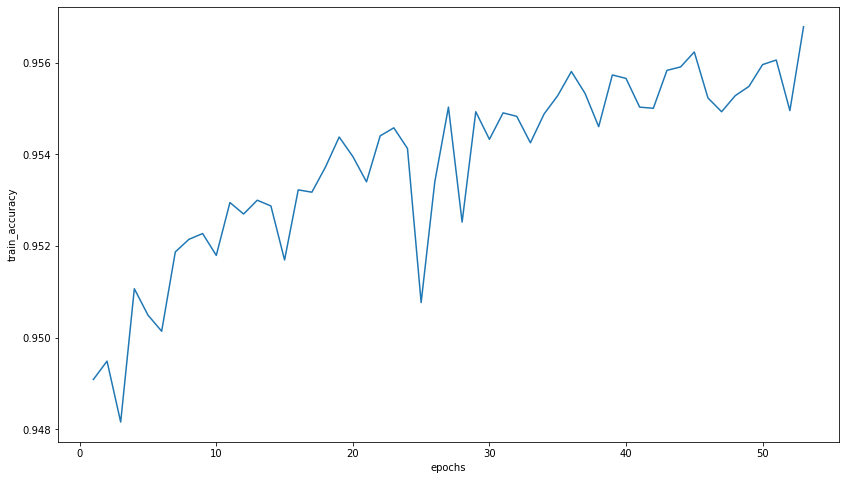

In [248]:
def fast_plot(Y):
    X = range(1, len(Y)+1)
    plt.figure(figsize = (14, 8))
    sns.lineplot(
        x = "epochs", y = "train_accuracy", 
        data = pd.DataFrame(np.vstack((X, Y)).T, columns=["epochs", "train_accuracy"])
    )

fast_plot(Y_elems)

In [245]:
model.eval()
test_labels, preds = make_predictions_mod(model, X_test, y_test, threshold=0.5, batch_size=batch_size)
# ...

Predicted label:    1
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Predicted label:    0
True label:  1.0
*

In [246]:
print(classification_report(test_labels, preds))
accuracy_score(test_labels, preds)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     12540
         1.0       0.80      0.33      0.47       743

    accuracy                           0.96     13283
   macro avg       0.88      0.66      0.72     13283
weighted avg       0.95      0.96      0.95     13283



0.9578408492057517

In [247]:
bool_save = True

if bool_save:
    import os
    torch.save(model.state_dict(), os.getcwd() + os.sep + 'FFNN_modified_satisfying.pth')

Как мы увидим в дальнейшем, качество обучения нейронной сети зависит от параметра learning rate (lr). 
Предугадать такое значение, при котором модель показывала максимально хорошие результаты - детская мечта. Ниже проверим поведение training accuracy и остальных измерений при lr = 0.81, 0.00001.
Хорошим тоном является фиксирование стартового learning rate со значением 0.01, а в дальнейшем уже будет зависеть от модели.

Epoch  1: train loss:     0.192902; train accuracy: 0.944996
Epoch  2: train loss:     0.180379; train accuracy: 0.948886
Epoch  3: train loss:     0.178785; train accuracy: 0.949639
Epoch  4: train loss:     0.169963; train accuracy: 0.944545
Epoch  5: train loss:     0.166148; train accuracy: 0.950843
Epoch  6: train loss:     0.170888; train accuracy: 0.950893
Epoch  7: train loss:     0.169721; train accuracy: 0.951772
Epoch  8: train loss:     0.170211; train accuracy: 0.951972
Epoch  9: train loss:     0.164674; train accuracy: 0.950843
Epoch 10: train loss:     0.166252; train accuracy: 0.951646
Epoch 11: train loss:     0.167947; train accuracy:  0.95147
Epoch 12: train loss:     0.167429; train accuracy: 0.949664
Epoch 13: train loss:     0.164203; train accuracy: 0.949965
Epoch 14: train loss:     0.166499; train accuracy:  0.95147
Epoch 15: train loss:     0.168336; train accuracy: 0.952499
Epoch 16: train loss:     0.164415; train accuracy: 0.952499
Epoch 17: train loss:   

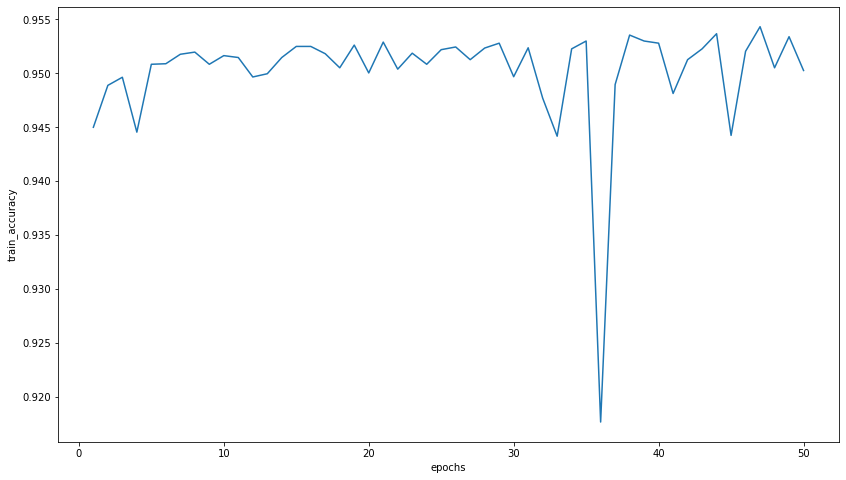

In [260]:
last_best_n = 50

Y_elems = []

model = FeedForwardModified(300, 180, 90)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.81)

model.train()

for epoch in range(last_best_n):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(X_train)), batch_size)
        x = X_train[idx]
        y_true = y_train[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()

    model.eval()
    current_acc = accuracy_train(model, X_train, y_train, batch_size)
    model.train()
        
    print('Epoch {:2}: train loss: {:12.6}; train accuracy: {:8.6}'.format(epoch+1, epoch_loss, current_acc))
    
    Y_elems.append(current_acc)
    if current_acc > 0.9565:
        break

model.eval()
test_labels, preds = make_predictions_mod(
    model, X_test, y_test, threshold=0.5, batch_size=batch_size, p = False)

print(classification_report(test_labels, preds))
print(accuracy_score(test_labels, preds))
        
fast_plot(Y_elems)

Epoch  1: train loss:     0.648901; train accuracy: 0.934357
Epoch  2: train loss:     0.610497; train accuracy: 0.940028
Epoch  3: train loss:     0.576074; train accuracy: 0.941935
Epoch  4: train loss:     0.545133; train accuracy: 0.943215
Epoch  5: train loss:     0.516439; train accuracy: 0.943641
Epoch  6: train loss:     0.490294; train accuracy: 0.943767
Epoch  7: train loss:     0.467172; train accuracy: 0.944043
Epoch  8: train loss:     0.446619; train accuracy: 0.944043
Epoch  9: train loss:      0.42391; train accuracy: 0.944043
Epoch 10: train loss:     0.406371; train accuracy: 0.944043
Epoch 11: train loss:     0.388735; train accuracy: 0.944043
Epoch 12: train loss:     0.375018; train accuracy: 0.944043
Epoch 13: train loss:     0.360805; train accuracy: 0.944043
Epoch 14: train loss:     0.345534; train accuracy: 0.944043
Epoch 15: train loss:     0.334873; train accuracy: 0.944043
Epoch 16: train loss:     0.324775; train accuracy: 0.944043
Epoch 17: train loss:   

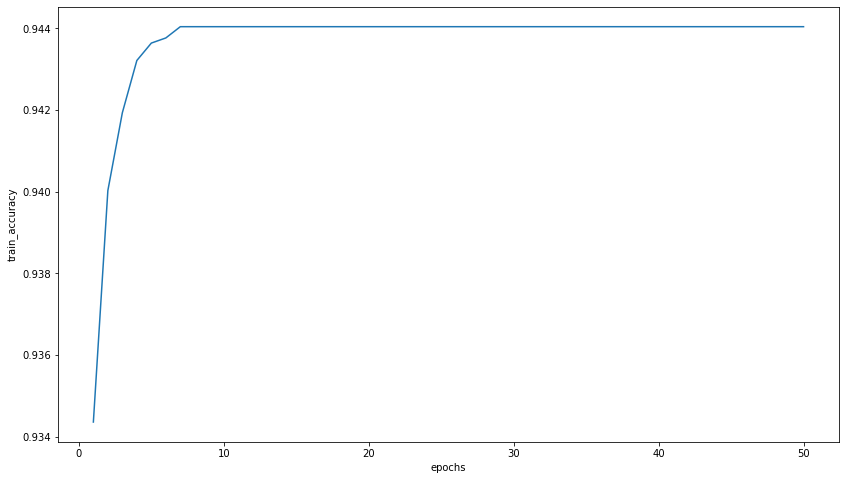

In [266]:
Y_elems = []

model = FeedForwardModified(300, 180, 90)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.00001)

model.train()

for epoch in range(last_best_n):  
    epoch_loss = 0
    
    for i in range(n_iters):
        optimizer.zero_grad()
        
        idx = random.sample(range(len(X_train)), batch_size)
        x = X_train[idx]
        y_true = y_train[idx]
        y_pred = model(x)
        
        loss = criterion(y_pred.squeeze(), y_true)
        epoch_loss += loss.item() / n_iters

        loss.backward()
        optimizer.step()

    model.eval()
    current_acc = accuracy_train(model, X_train, y_train, batch_size)
    model.train()
        
    print('Epoch {:2}: train loss: {:12.6}; train accuracy: {:8.6}'.format(epoch+1, epoch_loss, current_acc))
    
    Y_elems.append(current_acc)
    if current_acc > 0.9565:
        break

model.eval()
test_labels, preds = make_predictions_mod(
    model, X_test, y_test, threshold=0.5, batch_size=batch_size, p = False)

print(classification_report(test_labels, preds))
print(accuracy_score(test_labels, preds))
        
fast_plot(Y_elems)

## Task 2, advanced

Working with nn.Embedding layer 

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html 

Read an example below. 

Please, try to modify your initial version of the SingleLayerPerceptron model to the model with one additional layer: 

1. Define your vocabulary size  
2. Add nn.Embedding layer to the model architecture (vocabulary_size, embedding_size) 
3. Retrain your model - see if metrics increased.

### Useful parts for the part 2: 

Refer  to the part 4.3 of the course:

https://stepik.org/lesson/262247/

It will help you to get the understanding how to use an nn.Embedding layer. 

#####  Let's create a vocabulary: 

In [ ]:
def flat_nested(nested):
    flatten = []
    for item in nested:
        if isinstance(item, list):
            flatten.extend(item)
        else:
            flatten.append(item)
    return flatten

cnt_vocab = Counter(flat_nested(df.cleaned.tolist()))

In [ ]:
threshold_count_l = 15
threshold_count_h = 500
threshold_len = 4
cleaned_vocab = [token for token, count in cnt_vocab.items() if 
                     threshold_count_h > count > threshold_count_l and len(token) > threshold_len
                ]
print("Vocab size: {}".format(len(cleaned_vocab)))

In [ ]:
# You will need to have an id for each of your token 

token_to_id = {v: k for k, v in enumerate(sorted(cleaned_vocab))}
id_to_token = {v: k for k, v in token_to_id.items()}

In [ ]:
# in progress
class FeedForwardEnchanced(nn.Module):
    
    def __init__(self, n_uniq, emb_s, input_size, s1, s2):
        super().__init__()

        self.input_size = input_size
        
        self.s1 = s1
        self.s2 = s2
        
        self.embedding = nn.Embedding(n_uniq, emb_s)
        
        self.fc1 = nn.Linear(self.input_size, self.s1)
        self.fc2 = nn.Linear(self.s1, self.s2)
        self.fc3 = nn.Linear(self.s2, 1)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        embedding = self.emb(x)
        
        hidden_1 = self.fc1(embedding)
        hidden_1_a = self.relu(hidden_1)
        
        hidden_2 = self.fc2(hidden_1_a)
        hidden_2_a = self.tanh(hidden_2)

        pre_output = self.fc3(hidden_2_a)
        output = self.sigmoid(pre_output)

        return output